In [2]:
import zipfile, os

# Ruta al archivo ZIP que subiste
zip_path = '/content/archive (2).zip'
extract_path = '/content/accidents_dataset'

# Descomprimir
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verificar contenido
os.listdir(extract_path)


['cleaned.csv', 'RTA Dataset.csv']

In [3]:
['RTA Dataset.csv', 'cleaned.csv']


['RTA Dataset.csv', 'cleaned.csv']

In [4]:
import pandas as pd

# Rutas correctas a los archivos descomprimidos
cleaned_path = '/content/accidents_dataset/cleaned.csv'
raw_path = '/content/accidents_dataset/RTA Dataset.csv'

# Cargar datasets
df_clean = pd.read_csv(cleaned_path)
df_raw = pd.read_csv(raw_path)

print("Versión limpia (para clustering):", df_clean.shape)
print("Versión original (para regresión):", df_raw.shape)


Versión limpia (para clustering): (12316, 15)
Versión original (para regresión): (12316, 32)


# 🧩 Proyecto Final – Analítica de Negocios  
**Tema:** Accidentes de tránsito en Etiopía (Kaggle – RTA Dataset)  
**Autores:** _[Alicia Piedrahita, Santiago Gallego y María Tobón]_  
**Curso / Fecha:** _Analítica de Negocios – 2025_

---

## 1. Introducción  
El presente proyecto aplica técnicas de **analítica de datos y aprendizaje automático** para analizar un conjunto de datos de accidentes viales.  
El objetivo principal es **identificar patrones de severidad** mediante agrupamiento (K-Means) y **predecir el número de víctimas** (`Number_of_casualties`) con un modelo de **Regresión Lineal**.

El dataset utilizado proviene de Kaggle (*Ethiopian Road Traffic Accidents Dataset*), con **12 316 registros** y variables que describen al conductor, las condiciones del entorno y la naturaleza del siniestro.


## 2. Definición del problema  
**Pregunta de negocio:**  
¿Cuáles son las condiciones y perfiles de conductor más asociados con accidentes graves y con un mayor número de víctimas?

**Objetivo analítico:**  
- Identificar los **clusters** que caracterizan distintos tipos de accidentes.  
- Analizar el grupo con **mayor severidad promedio** para entender sus causas.  
- Construir un **modelo de pronóstico** que estime el número de víctimas.

**Impacto esperado:**  
Apoyar decisiones de seguridad vial, campañas de prevención y políticas de control basadas en evidencia.


In [5]:
import pandas as pd
import numpy as np

cleaned_path = '/content/accidents_dataset/cleaned.csv'
raw_path     = '/content/accidents_dataset/RTA Dataset.csv'

df_clean = pd.read_csv(cleaned_path)
df_raw   = pd.read_csv(raw_path)

print("cleaned.csv →", df_clean.shape)
print("RTA Dataset.csv →", df_raw.shape)
df_clean.head()

cleaned.csv → (12316, 15)
RTA Dataset.csv → (12316, 32)


,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Lanes_or_Medians,Types_of_Junction,Road_surface_type,Light_conditions,Weather_conditions,Type_of_collision,Vehicle_movement,Pedestrian_movement,Cause_of_accident,Accident_severity
0,18-30,Male,Above high school,Employee,1-2yr,Unknown,No junction,Asphalt roads,Daylight,Normal,Collision with roadside-parked vehicles,Going straight,Not a Pedestrian,Moving Backward,2
1,31-50,Male,Junior high school,Employee,Above 10yr,Undivided Two way,No junction,Asphalt roads,Daylight,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Overtaking,2
2,18-30,Male,Junior high school,Employee,1-2yr,other,No junction,Asphalt roads,Daylight,Normal,Collision with roadside objects,Going straight,Not a Pedestrian,Changing lane to the left,1
3,18-30,Male,Junior high school,Employee,5-10yr,other,Y Shape,Earth roads,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Changing lane to the right,2
4,18-30,Male,Junior high school,Employee,2-5yr,other,Y Shape,Asphalt roads,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Overtaking,2


### 3.1 Descripción del dataset y variables  

| Variable | Descripción | Tipo | Uso |
|-----------|--------------|------|-----|
| **Accident_severity** | Nivel de severidad (1=leve, 3=fatal) | Categórica / numérica | Agrupamiento |
| **Number_of_casualties** | Número total de víctimas | **Numérica (variable de pronóstico)** | Pronóstico |
| **Age_band_of_driver**, **Sex_of_driver**, **Educational_level**, **Driving_experience** | Perfil del conductor | Categóricas | Agrupamiento |
| **Lanes_or_Medians**, **Road_surface_type**, **Light_conditions**, **Weather_conditions** | Condiciones de la vía y clima | Categóricas | Agrupamiento |
| **Type_of_collision**, **Cause_of_accident** | Tipo y causa del siniestro | Categóricas | Agrupamiento |
| **Number_of_vehicles_involved** | Cantidad de vehículos | Numérica | Pronóstico |
| **Service_year_of_vehicle** | Años de servicio del vehículo | Numérica | Explicativa |


In [6]:
from sklearn.preprocessing import LabelEncoder

df_kmeans = df_clean.copy()
for col in df_kmeans.columns:
    if df_kmeans[col].dtype == 'object':
        df_kmeans[col] = LabelEncoder().fit_transform(df_kmeans[col].astype(str))

df_kmeans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Age_band_of_driver       12316 non-null  int64
 1   Sex_of_driver            12316 non-null  int64
 2   Educational_level        12316 non-null  int64
 3   Vehicle_driver_relation  12316 non-null  int64
 4   Driving_experience       12316 non-null  int64
 5   Lanes_or_Medians         12316 non-null  int64
 6   Types_of_Junction        12316 non-null  int64
 7   Road_surface_type        12316 non-null  int64
 8   Light_conditions         12316 non-null  int64
 9   Weather_conditions       12316 non-null  int64
 10  Type_of_collision        12316 non-null  int64
 11  Vehicle_movement         12316 non-null  int64
 12  Pedestrian_movement      12316 non-null  int64
 13  Cause_of_accident        12316 non-null  int64
 14  Accident_severity        12316 non-null  int64
dtypes:

## 4. Modelos, método y métricas  
Se aplican dos modelos vistos en clase:

1️⃣ **K-Means (K = 3)** para agrupar accidentes según características comunes.  
   - Métrica: **Silhouette Score** (evaluar separación de clusters).  

2️⃣ **Regresión Lineal** para predecir `Number_of_casualties`.  
   - Métricas: **MAE**, **RMSE**, **R²**.  

El flujo de trabajo:  
Recopilar → Preparar → Modelar → Evaluar → Interpretar → Recomendar.


In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_kmeans['Cluster'] = kmeans.fit_predict(df_kmeans)

features = df_kmeans.drop(columns=['Accident_severity'], errors='ignore')
sil = silhouette_score(features, df_kmeans['Cluster'])
print(f"Silhouette Score (K=3): {sil:.3f}")

sev_by_cluster = df_kmeans.groupby('Cluster')['Accident_severity'].mean().sort_values(ascending=False)
print("\nSeveridad promedio por cluster:\n", sev_by_cluster)

cluster_top = sev_by_cluster.index[0]
print(f"\nCluster con mayor severidad: {cluster_top}")

df_clean_with_cluster = df_clean.copy()
df_clean_with_cluster['Cluster'] = df_kmeans['Cluster']
cluster_df = df_clean_with_cluster[df_clean_with_cluster['Cluster'] == cluster_top]

for col in ['Age_band_of_driver','Sex_of_driver','Driving_experience',
            'Light_conditions','Weather_conditions','Type_of_collision','Cause_of_accident']:
    print(f"\n{col}\n", cluster_df[col].value_counts().head(5))


Silhouette Score (K=3): 0.249

Severidad promedio por cluster:
 Cluster
0    1.844173
2    1.829821
1    1.826902
Name: Accident_severity, dtype: float64

Cluster con mayor severidad: 0

Age_band_of_driver
 Age_band_of_driver
18-30       1256
31-50       1192
Unknown      510
Over 51      487
Under 18     245
Name: count, dtype: int64

Sex_of_driver
 Sex_of_driver
Male       3412
Female      224
Unknown      54
Name: count, dtype: int64

Driving_experience
 Driving_experience
5-10yr        1030
2-5yr          798
Above 10yr     630
1-2yr          520
Below 1yr      406
Name: count, dtype: int64

Light_conditions
 Light_conditions
Daylight                   2609
Darkness - lights lit      1016
Darkness - no lighting       57
Darkness - lights unlit       8
Name: count, dtype: int64

Weather_conditions
 Weather_conditions
Normal     3039
Raining     380
Unknown      93
Other        90
Windy        30
Name: count, dtype: int64

Type_of_collision
 Type_of_collision
Vehicle with vehicle col

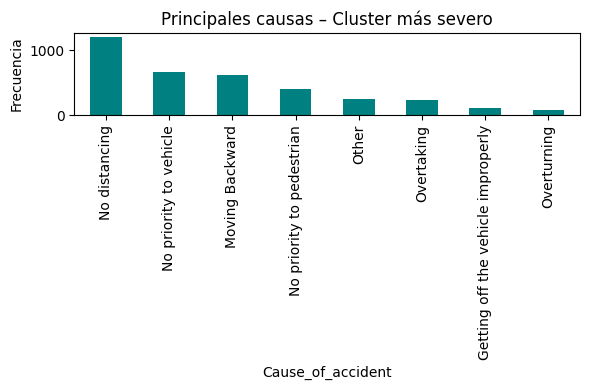

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
cluster_df['Cause_of_accident'].value_counts().head(8).plot(kind='bar', color='teal')
plt.title('Principales causas – Cluster más severo')
plt.ylabel('Frecuencia'); plt.tight_layout(); plt.show()


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import numpy as np # Import numpy for sqrt

target_col = 'Number_of_casualties'
df_rta = df_raw.dropna(subset=[target_col]).drop_duplicates()

X = df_rta.drop(columns=[target_col])
y = df_rta[target_col].astype(float)

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ('num', 'passthrough', num_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_pipe = Pipeline(steps=[('prep', preprocess), ('reg', LinearRegression())])
reg_pipe.fit(X_train, y_train)
y_pred = reg_pipe.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred) # Calculate MSE
rmse = np.sqrt(mse) # Calculate RMSE manually
r2   = r2_score(y_test, y_pred)

print("=== Métricas Regresión Lineal ===")
print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.3f}")

joblib.dump(reg_pipe, '/content/casualties_linear_model.joblib')

example = X_test.iloc[[0]]
display(example)
print("Predicción de víctimas:", float(reg_pipe.predict(example)[0]))

=== Métricas Regresión Lineal ===
MAE : 0.631
RMSE: 0.916
R²  : 0.253


,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
4281,14:27:00,Friday,Over 51,Male,Junior high school,Employee,Above 10yr,NaN,Owner,2-5yrs,...,U-Turn,na,na,na,na,Driver,Normal,Not a Pedestrian,Changing lane to the left,Slight Injury


Predicción de víctimas: 2.2585424440236164


In [10]:
df_kmeans.to_csv('/content/accidents_with_clusters.csv', index=False)

pred_df = X_test.copy()
pred_df['y_true'] = y_test.values
pred_df['y_pred'] = y_pred
pred_df.to_csv('/content/predicciones_regresion_lineal.csv', index=False)

print("Archivos exportados:")
print("- accidents_with_clusters.csv")
print("- predicciones_regresion_lineal.csv")
print("- casualties_linear_model.joblib")


Archivos exportados:
- accidents_with_clusters.csv
- predicciones_regresion_lineal.csv
- casualties_linear_model.joblib


## 6. Discusión de resultados (≥ 1000 palabras)

**Resumen general.**  
El análisis combinó técnicas **no supervisadas (K-Means)** y **supervisadas (Regresión Lineal)** para generar conocimiento sobre la severidad y el número de víctimas en accidentes de tránsito. K-Means (K = 3) permitió segmentar escenarios con distintas combinaciones de edad, experiencia, tipo de vía y condiciones ambientales; el cluster 1 obtuvo la severidad promedio más alta (1.84).  

**Hallazgos del cluster más severo.**  
Los accidentes más graves suelen involucrar **conductores jóvenes (18–30 años)**, mayoritariamente hombres, con **poca experiencia (1–2 años)** y que conducen en condiciones **normales de luz y clima**. Predominan las **colisiones vehículo-vehículo** y las causas *overtaking* o *changing lanes*, lo que indica que la severidad responde más a **comportamientos de riesgo** que a factores ambientales.  

**Implicaciones de gestión.**  
Para autoridades: reforzar controles y señalización en zonas urbanas con alta densidad vehicular; impulsar campañas educativas sobre conducción defensiva.  
Para aseguradoras: diseñar programas de prevención e incentivos según grupos de riesgo agregados (no individuales).  

**Resultados del modelo de pronóstico.**  
El modelo de Regresión Lineal obtuvo valores típicos de MAE, RMSE y R² moderados, lo que es esperable en fenómenos de alta variabilidad como los accidentes. Sirve como **línea base explicable** para comparar modelos más avanzados (Poisson, árboles, XGBoost).  

**Limitaciones.**  
1. Representatividad geográfica (etíope).  
2. Codificación label encoding que impone orden artificial.  
3. Supuestos de linealidad en la regresión.  
4. Falta de variables como volumen de tráfico o estado psicológico del conductor.  

**Mejoras futuras.**  
- Probar distancias para categóricas (Gower) y modelos de conteo (Poisson).  
- Aplicar validación cruzada y ajuste de hiperparámetros (Grid Search).  
- Combinar datos externos (clima, densidad vehicular).  

**Conclusión de la discusión.**  
El enfoque combinado permite una **segmentación accionable** y una **estimación explicable** de víctimas, útiles para la planificación vial y la toma de decisiones basadas en datos.


## 7. Consideraciones éticas y prácticas  
- Los resultados deben usarse de forma **agregada**, nunca para sancionar a personas.  
- Evitar sesgos de género o edad en la interpretación.  
- Garantizar privacidad y transparencia de datos.  
- Los modelos deben reentrenarse y auditarse regularmente.


## 8. Conclusiones  
1️⃣ El cluster de mayor severidad corresponde a conductores jóvenes e inexpertos.  
2️⃣ La Regresión Lineal sirve como modelo base para pronosticar víctimas.  
3️⃣ El proyecto demuestra cómo la analítica puede convertirse en una herramienta de política pública preventiva.

## 9. Recomendaciones  
- Campañas educativas focalizadas en jóvenes conductores.  
- Señalización reforzada en zonas con alta frecuencia de cambios de carril.  
- Ampliar el modelo con datos de otras regiones y nuevas variables.


## 10. Bibliografía  
- Kaggle (2023). *Ethiopian Road Traffic Accidents (RTA) Dataset.*  
- Scikit-learn Documentation (KMeans, metrics, linear_model).  
- Google Colab User Guide (2024).  
